# Practical 3

# Optimizing parameters and additional metrics using biases only

In [1]:
import csv
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid

### Loading Data and Creating Index Mappings

In [ ]:
# Initialize dictionaries to hold mappings and lists to hold the transformed data
user_to_index = {}
movie_to_index = {}
user_ratings = defaultdict(list)

# Load data from CSV file and sort temporally
with open('./ml-latest-small/ratings.csv', encoding='utf-8') as file:
    csv_reader = csv.reader(file)
    next(csv_reader)  # Skip the header row
    for row in csv_reader:
        user_id = int(row[0])
        movie_id = int(row[1])
        rating = float(row[2])
        timestamp = int(row[3])

        if user_id not in user_to_index:
            user_to_index[user_id] = len(user_to_index)
        if movie_id not in movie_to_index:
            movie_to_index[movie_id] = len(movie_to_index)

        user_ratings[user_id].append((movie_id, rating, timestamp))

# Sort ratings for each user by timestamp
for user_id in user_ratings:
    user_ratings[user_id].sort(key=lambda x: x[2])  # Sort by timestamp

### Splitting Data into Training and Test Sets

In [ ]:
# Define the number of last ratings to use as test data
m = 5  # Use last 5 ratings of each user for testing

# Split the data into training and test sets
train_user_ids, train_movie_ids, train_ratings = [], [], []
test_user_ids, test_movie_ids, test_ratings = [], [], []

for user_id, ratings in user_ratings.items():
    user_idx = user_to_index[user_id]
    if len(ratings) > m:
        # Training data
        for movie_id, rating, _ in ratings[:-m]:
            train_user_ids.append(user_idx)
            train_movie_ids.append(movie_to_index[movie_id])
            train_ratings.append(rating)
        # Test data
        for movie_id, rating, _ in ratings[-m:]:
            test_user_ids.append(user_idx)
            test_movie_ids.append(movie_to_index[movie_id])
            test_ratings.append(rating)
    else:
        # Use all for training if not enough ratings
        for movie_id, rating, _ in ratings:
            train_user_ids.append(user_idx)
            train_movie_ids.append(movie_to_index[movie_id])
            train_ratings.append(rating)

### Handling Cold Start Items

In [ ]:
# Convert lists to numpy arrays
train_user_ids = np.array(train_user_ids)
train_movie_ids = np.array(train_movie_ids)
train_ratings = np.array(train_ratings)
test_user_ids = np.array(test_user_ids)
test_movie_ids = np.array(test_movie_ids)
test_ratings = np.array(test_ratings)

# Check for cold start items in the test set
train_movie_set = set(train_movie_ids)
cold_start_indices = [i for i, movie_id in enumerate(test_movie_ids) if movie_id not in train_movie_set]

# Add cold start items to the training set
if cold_start_indices:
    train_user_ids = np.concatenate((train_user_ids, test_user_ids[cold_start_indices]))
    train_movie_ids = np.concatenate((train_movie_ids, test_movie_ids[cold_start_indices]))
    train_ratings = np.concatenate((train_ratings, test_ratings[cold_start_indices]))

### Re-indexing the Data

In [ ]:
# Prepare new index mappings based on the training set
train_user_to_index = {uid: idx for idx, uid in enumerate(np.unique(train_user_ids))}
train_movie_to_index = {mid: idx for idx, mid in enumerate(np.unique(train_movie_ids))}

# Apply the new indexing to the training data
indexed_train_user_ids = np.array([train_user_to_index[uid] for uid in train_user_ids])
indexed_train_movie_ids = np.array([train_movie_to_index[mid] for mid in train_movie_ids])

# Remap test user and movie indices
indexed_test_user_ids = np.array([train_user_to_index.get(uid, -1) for uid in test_user_ids])
indexed_test_movie_ids = np.array([train_movie_to_index.get(mid, -1) for mid in test_movie_ids])

# Filter valid test indices to ensure they are known in the training set
valid_test_indices = (indexed_test_user_ids != -1) & (indexed_test_movie_ids != -1)

test_user_ids = indexed_test_user_ids[valid_test_indices]
test_movie_ids = indexed_test_movie_ids[valid_test_indices]
test_ratings = test_ratings[valid_test_indices]

# Output the shapes of the training and test sets
print("Training data:", indexed_train_user_ids.shape, indexed_train_movie_ids.shape, train_ratings.shape)
print("Test data:", test_user_ids.shape, test_movie_ids.shape, test_ratings.shape)

# Report the number of cold start items
total_test_items = len(test_movie_ids)
removed_count = len(cold_start_indices)
print(f"Total test items: {total_test_items}")
print(f"Cold start items added to training set: {removed_count}")
print(f"Percentage of cold start items: {removed_count / total_test_items * 100:.2f}%")

Training data: (97896,) (97896,) (97896,)
Test data: (3050,) (3050,) (3050,)
Total test items: 3050
Cold start items added to training set: 110
Percentage of cold start items: 3.61%


In [ ]:
def initialize_factors(user_ids, movie_ids, num_factors):
    unique_users = np.unique(user_ids)
    unique_movies = np.unique(movie_ids)
    user_bias = np.zeros(len(unique_users))
    item_bias = np.zeros(len(unique_movies))
    user_factors = np.random.normal(0, 0.1, (len(unique_users), num_factors))
    item_factors = np.random.normal(0, 0.1, (len(unique_movies), num_factors))
    return user_bias, item_bias, user_factors, item_factors

def calculate_loss(user_ids, movie_ids, ratings, user_bias, item_bias, user_factors, item_factors, lambda_reg, gamma_latent, gamma_bias):
    predictions = user_bias[user_ids] + item_bias[movie_ids] + np.sum(user_factors[user_ids] * item_factors[movie_ids], axis=1)
    errors = ratings - predictions
    loss = 0.5 * np.sum(errors**2)
    regularization_bias = 0.5 * gamma_bias * (np.sum(user_bias**2) + np.sum(item_bias**2))
    regularization_factors = 0.5 * gamma_latent * (np.sum(user_factors**2) + np.sum(item_factors**2))
    return lambda_reg * loss + regularization_bias + regularization_factors

def calculate_rmse(user_ids, movie_ids, ratings, user_bias, item_bias, user_factors, item_factors):
    predictions = user_bias[user_ids] + item_bias[movie_ids] + np.sum(user_factors[user_ids] * item_factors[movie_ids], axis=1)
    errors = ratings - predictions
    mse = np.mean(errors**2)  # Mean Squared Error
    return np.sqrt(mse)  # Root Mean Squared Error

def predict_rating(user_ids, movie_ids, user_bias, item_bias, user_factors, item_factors):
    dot_products = np.sum(user_factors[user_ids] * item_factors[movie_ids], axis=1)
    predictions = user_bias[user_ids] + item_bias[movie_ids] + dot_products
    return predictions

In [ ]:
def calculate_rmse(predictions, actual_ratings):
    mse = np.mean((predictions - actual_ratings) ** 2)
    return np.sqrt(mse)

In [ ]:
def update_user_bias(user_ids, movie_ids, ratings, user_bias, item_bias, user_factors, item_factors, lambda_reg, gamma_bias):
    # Calculate user biases using the ALS algorithm
    for user_id in np.unique(user_ids):
        indices = np.where(user_ids == user_id)[0]
        item_indices = movie_ids[indices]
        ratings_subset = ratings[indices]
        item_bias_subset = item_bias[item_indices]
        user_factor = user_factors[user_id]
        item_factors_subset = item_factors[item_indices]

        num_items = len(indices)
        dot_product = np.dot(item_factors_subset, user_factor)

        # Update equation implementation
        numerator = lambda_reg * np.sum(ratings_subset - item_bias_subset - dot_product)
        denominator = lambda_reg * num_items + gamma_bias
        user_bias[user_id] = numerator / denominator

    return user_bias

def update_item_bias(user_ids, movie_ids, ratings, user_bias, item_bias, user_factors, item_factors, lambda_reg, gamma_bias):
    # Calculate item biases using the ALS algorithm
    for movie_id in np.unique(movie_ids):
        indices = np.where(movie_ids == movie_id)[0]
        user_indices = user_ids[indices]
        ratings_subset = ratings[indices]
        user_bias_subset = user_bias[user_indices]
        item_factor = item_factors[movie_id]
        user_factors_subset = user_factors[user_indices]

        num_users = len(indices)
        dot_product = np.dot(user_factors_subset, item_factor)

        # Update equation implementation
        numerator = lambda_reg * np.sum(ratings_subset - user_bias_subset - dot_product)
        denominator = lambda_reg * num_users + gamma_bias
        item_bias[movie_id] = numerator / denominator

    return item_bias

In [ ]:
def update_user_factors(user_ids, movie_ids, ratings, user_bias, item_bias, user_factors, item_factors, lambda_reg, gamma_latent):
    for user_id in np.unique(user_ids):
        indices = np.where(user_ids == user_id)[0]
        V_i = item_factors[movie_ids[indices]]
        A = lambda_reg * np.dot(V_i.T, V_i) + gamma_latent * np.eye(V_i.shape[1])
        residuals = ratings[indices] - user_bias[user_id] - item_bias[movie_ids[indices]]
        b = lambda_reg * np.sum(residuals[:, np.newaxis] * V_i, axis=0)
        user_factors[user_id] = np.linalg.solve(A, b)
    return user_factors

def update_item_factors(user_ids, movie_ids, ratings, user_bias, item_bias, user_factors, item_factors, lambda_reg, gamma_latent):
    for movie_id in np.unique(movie_ids):
        indices = np.where(movie_ids == movie_id)[0]
        U_j = user_factors[user_ids[indices]]
        A = lambda_reg * np.dot(U_j.T, U_j) + gamma_latent * np.eye(U_j.shape[1])
        residuals = ratings[indices] - user_bias[user_ids[indices]] - item_bias[movie_id]
        b = lambda_reg * np.sum(residuals[:, np.newaxis] * U_j, axis=0)
        item_factors[movie_id] = np.linalg.solve(A, b)
    return item_factors

In [ ]:
def alternating_least_squares(train_user_ids, train_movie_ids, train_ratings, test_user_ids, test_movie_ids, test_ratings, iterations, num_factors, lambda_reg, gamma_latent, gamma_bias):
    user_bias, item_bias, user_factors, item_factors = initialize_factors(train_user_ids, train_movie_ids, num_factors)
    train_rmses = []
    test_rmses = []
    train_losses = []
    test_losses = []

    for iteration in range(iterations):
        user_bias = update_user_bias(train_user_ids, train_movie_ids, train_ratings, user_bias, item_bias, user_factors, item_factors, lambda_reg, gamma_bias)
        item_bias = update_item_bias(train_user_ids, train_movie_ids, train_ratings, user_bias, item_bias, user_factors, item_factors, lambda_reg, gamma_bias)

        user_factors = update_user_factors(train_user_ids, train_movie_ids, train_ratings, user_bias, item_bias, user_factors, item_factors, lambda_reg, gamma_latent)
        item_factors = update_item_factors(train_user_ids, train_movie_ids, train_ratings, user_bias, item_bias, user_factors, item_factors, lambda_reg, gamma_latent)

        # Compute predictions and RMSE for training set
        train_predictions = predict_rating(train_user_ids, train_movie_ids, user_bias, item_bias, user_factors, item_factors)
        train_rmse = calculate_rmse(train_predictions, train_ratings)
        train_rmses.append(train_rmse)
        train_loss = calculate_loss(train_user_ids, train_movie_ids, train_ratings, user_bias, item_bias, user_factors, item_factors, lambda_reg, gamma_latent, gamma_bias)
        train_losses.append(train_loss)

        # Compute predictions and RMSE for test set
        test_predictions = predict_rating(test_user_ids, test_movie_ids, user_bias, item_bias, user_factors, item_factors)
        test_rmse = calculate_rmse(test_predictions, test_ratings)
        test_rmses.append(test_rmse)
        test_loss = calculate_loss(test_user_ids, test_movie_ids, test_ratings, user_bias, item_bias, user_factors, item_factors, lambda_reg, gamma_latent, gamma_bias)
        test_losses.append(test_loss)

        print(f"Iteration {iteration + 1}, Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    return user_bias, item_bias, user_factors, item_factors, train_rmses, test_rmses, train_losses, test_losses

In [ ]:
# Hyperparameters
epochs = 10
k = 10 # Number of latent dimensions
lambda_reg = 0.2 # Error scaling factor
gamma_latent = 5     # Regularization parameter for latent factor vectors
gamma_bias = 0.4     # Regularization parameter for biases

# Hyperparameter grid
param_grid = {
    'k': [5, 10, 20],
    'lambda_reg': [0.1, 0.2, 0.3, 0.4, 0.5],
    'gamma_latent': [0.1, 0.2, 0.3, 0.4, 0.5],
    'gamma_bias': [0.1, 0.2, 0.3, 0.4, 0.5]
}

# Grid search
best_params = None
best_rmse = float('inf')

for params in ParameterGrid(param_grid):
    print(f"Testing params: {params}")
    user_bias, item_bias, user_factors, item_factors, train_rmses, test_rmses, train_losses, test_losses = alternating_least_squares(
        train_user_ids, train_movie_ids, train_ratings, test_user_ids, test_movie_ids, test_ratings,
        epochs, params['k'], params['lambda_reg'], params['gamma_latent'], params['gamma_bias']
    )
    mean_rmse = np.mean(test_rmses)
    print(f"Mean RMSE: {mean_rmse}")

    if mean_rmse < best_rmse:
        best_rmse = mean_rmse
        best_params = params

print(f"Best params: {best_params}")
print(f"Best RMSE: {best_rmse}")

Testing params: {'gamma_bias': 0.1, 'gamma_latent': 0.1, 'k': 5, 'lambda_reg': 0.1}
Iteration 1, Train RMSE: 0.7188, Test RMSE: 0.9762, Train Loss: 3214.0645, Test Loss: 830.5354
Iteration 2, Train RMSE: 0.6606, Test RMSE: 0.9722, Train Loss: 2827.3306, Test Loss: 835.4385
Iteration 3, Train RMSE: 0.6391, Test RMSE: 0.9718, Train Loss: 2671.2787, Test Loss: 816.2286
Iteration 4, Train RMSE: 0.6275, Test RMSE: 0.9737, Train Loss: 2583.0682, Test Loss: 800.4762
Iteration 5, Train RMSE: 0.6202, Test RMSE: 0.9770, Train Loss: 2526.1675, Test Loss: 788.9587
Iteration 6, Train RMSE: 0.6152, Test RMSE: 0.9806, Train Loss: 2486.2934, Test Loss: 780.3396
Iteration 7, Train RMSE: 0.6116, Test RMSE: 0.9837, Train Loss: 2456.5789, Test Loss: 773.4544
Iteration 8, Train RMSE: 0.6088, Test RMSE: 0.9860, Train Loss: 2433.2898, Test Loss: 767.6451
Iteration 9, Train RMSE: 0.6065, Test RMSE: 0.9875, Train Loss: 2414.3036, Test Loss: 762.5852
Iteration 10, Train RMSE: 0.6046, Test RMSE: 0.9881, Train Lo

In [ ]:
# Hyperparameters
epochs = 10
k = 10 # Number of latent dimensions
lambda_reg = 0.1 # Error scaling factor
gamma_latent = 0.5     # Regularization parameter for latent factor vectors
gamma_bias = 0.1     # Regularization parameter for biases

# Final model training with the best parameters
user_bias, item_bias, user_factors, item_factors, train_rmses, test_rmses, train_losses, test_losses = alternating_least_squares(
    train_user_ids, train_movie_ids, train_ratings, test_user_ids, test_movie_ids, test_ratings,
    epochs, k, lambda_reg, gamma_latent, gamma_bias
)

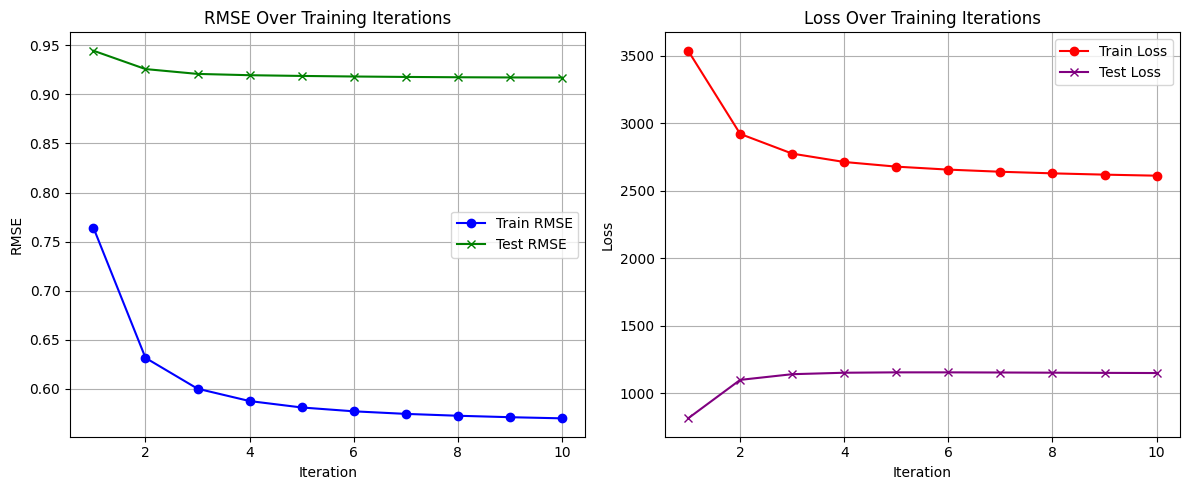

In [ ]:
iterations = list(range(1, len(train_rmses) + 1))

# Set up the figure and the subplots
plt.figure(figsize=(12, 5))  # Adjust figure size to a reasonable dimension for two plots

# Plotting the Train and Test RMSE over iterations
plt.subplot(1, 2, 1)  # Using 1 row, 2 columns, position 1
plt.plot(iterations, train_rmses, marker='o', linestyle='-', color='blue', label='Train RMSE')
plt.plot(iterations, test_rmses, marker='x', linestyle='-', color='green', label='Test RMSE')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('RMSE Over Training Iterations')
plt.legend()
plt.grid(True)

# Plotting the Train and Test Loss over iterations
plt.subplot(1, 2, 2)  # Using 1 row, 2 columns, position 2
plt.plot(iterations, train_losses, marker='o', linestyle='-', color='red', label='Train Loss')
plt.plot(iterations, test_losses, marker='x', linestyle='-', color='purple', label='Test Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Over Training Iterations')
plt.legend()
plt.grid(True)  # Optional, adds grid for better readability

plt.tight_layout()
plt.show()

# Training on 25m dataset using Google Colab and doing calculations on a GPU

In [2]:
!pip install torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import csv
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import pickle
import os

In [5]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize dictionaries to hold mappings and lists to hold the transformed data
user_to_index = {}
movie_to_index = {}
user_ratings = defaultdict(list)

# Load data from CSV file and sort temporally
with open('./drive/MyDrive/AMAS_PROJECT/AMAS(2)/ml-25m/ratings.csv', encoding='utf-8') as file:
    csv_reader = csv.reader(file)
    next(csv_reader)  # Skip the header row
    for row in csv_reader:
        user_id = int(row[0])
        movie_id = int(row[1])
        rating = float(row[2])
        timestamp = int(row[3])

        if user_id not in user_to_index:
            user_to_index[user_id] = len(user_to_index)
        if movie_id not in movie_to_index:
            movie_to_index[movie_id] = len(movie_to_index)

        user_ratings[user_id].append((movie_id, rating, timestamp))

# Sort ratings for each user by timestamp
for user_id in user_ratings:
    user_ratings[user_id].sort(key=lambda x: x[2])  # Sort by timestamp

# Prepare the data for training
train_user_ids, train_movie_ids, train_ratings = [], [], []

for user_id, ratings in user_ratings.items():
    user_idx = user_to_index[user_id]
    for movie_id, rating, _ in ratings:
        train_user_ids.append(user_idx)
        train_movie_ids.append(movie_to_index[movie_id])
        train_ratings.append(rating)

# Convert lists to numpy arrays
train_user_ids = np.array(train_user_ids)
train_movie_ids = np.array(train_movie_ids)
train_ratings = np.array(train_ratings)

# Prepare new index mappings based on the training set
train_user_to_index = {uid: idx for idx, uid in enumerate(np.unique(train_user_ids))}
train_movie_to_index = {mid: idx for idx, mid in enumerate(np.unique(train_movie_ids))}

# Apply the new indexing to the training data
indexed_train_user_ids = np.array([train_user_to_index[uid] for uid in train_user_ids])
indexed_train_movie_ids = np.array([train_movie_to_index[mid] for mid in train_movie_ids])

# Convert to PyTorch tensors and move to the device
train_user_ids = torch.tensor(indexed_train_user_ids, dtype=torch.long, device=device)
train_movie_ids = torch.tensor(indexed_train_movie_ids, dtype=torch.long, device=device)
train_ratings = torch.tensor(train_ratings, dtype=torch.float32, device=device)

# Output the shapes of the training data
print("Training data:", train_user_ids.shape, train_movie_ids.shape, train_ratings.shape)

Training data: torch.Size([25000095]) torch.Size([25000095]) torch.Size([25000095])


In [6]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize dictionaries to hold mappings and lists to hold the transformed data
user_to_index = {}
movie_to_index = {}
user_ratings = defaultdict(list)

# Load data from CSV file and sort temporally
with open('./drive/MyDrive/AMAS_PROJECT/AMAS(2)/ml-25m/ratings.csv', encoding='utf-8') as file:
    csv_reader = csv.reader(file)
    next(csv_reader)  # Skip the header row
    for row in csv_reader:
        user_id = int(row[0])
        movie_id = int(row[1])
        rating = float(row[2])
        timestamp = int(row[3])

        if user_id not in user_to_index:
            user_to_index[user_id] = len(user_to_index)
        if movie_id not in movie_to_index:
            movie_to_index[movie_id] = len(movie_to_index)

        user_ratings[user_id].append((movie_id, rating, timestamp))

# Sort ratings for each user by timestamp
for user_id in user_ratings:
    user_ratings[user_id].sort(key=lambda x: x[2])  # Sort by timestamp

# Prepare the data for training
train_user_ids, train_movie_ids, train_ratings = [], [], []

for user_id, ratings in user_ratings.items():
    user_idx = user_to_index[user_id]
    for movie_id, rating, _ in ratings:
        train_user_ids.append(user_idx)
        train_movie_ids.append(movie_to_index[movie_id])
        train_ratings.append(rating)

# Convert lists to numpy arrays
train_user_ids = np.array(train_user_ids)
train_movie_ids = np.array(train_movie_ids)
train_ratings = np.array(train_ratings)

# Debugging Step 1: Ensure that all movie IDs in the ratings file are correctly mapped
print("Verifying mappings between original movie IDs and internal indices...")
for original_id in movie_to_index.keys():
    if original_id not in movie_to_index:
        print(f"Error: Original movie ID {original_id} is missing in the movie_to_index mapping!")

# Debugging Step 2: Ensure that every original movie ID maps back correctly
train_movie_to_index = {mid: idx for idx, mid in enumerate(np.unique(train_movie_ids))}
index_to_movie_id = {idx: mid for mid, idx in train_movie_to_index.items()}
print("Verifying reverse mappings from indices to original movie IDs...")
for idx, original_id in index_to_movie_id.items():
    if original_id not in movie_to_index:
        print(f"Error: Mapped movie ID {original_id} at index {idx} is not found in the original movie ID mapping!")

# Prepare new index mappings based on the training set
train_user_to_index = {uid: idx for idx, uid in enumerate(np.unique(train_user_ids))}
train_movie_to_index = {mid: idx for idx, mid in enumerate(np.unique(train_movie_ids))}

# Apply the new indexing to the training data
indexed_train_user_ids = np.array([train_user_to_index[uid] for uid in train_user_ids])
indexed_train_movie_ids = np.array([train_movie_to_index[mid] for mid in train_movie_ids])

# Debugging Step 3: Ensure that indices are unique and correctly mapped
print("Checking if indices are unique and correctly mapped...")
assert len(set(indexed_train_movie_ids)) == len(indexed_train_movie_ids), "Error: Duplicate indices found in indexed_train_movie_ids!"
assert len(set(indexed_train_user_ids)) == len(indexed_train_user_ids), "Error: Duplicate indices found in indexed_train_user_ids!"

# Convert to PyTorch tensors and move to the device
train_user_ids = torch.tensor(indexed_train_user_ids, dtype=torch.long, device=device)
train_movie_ids = torch.tensor(indexed_train_movie_ids, dtype=torch.long, device=device)
train_ratings = torch.tensor(train_ratings, dtype=torch.float32, device=device)

# Debugging Step 4: Ensure that the PyTorch tensors are correctly shaped and populated
print("Checking the shapes of the PyTorch tensors...")
assert train_user_ids.shape == train_movie_ids.shape == train_ratings.shape, "Error: Shapes of user_ids, movie_ids, and ratings do not match!"

# Output the shapes of the training data
print("Training data:", train_user_ids.shape, train_movie_ids.shape, train_ratings.shape)


Streaming output truncated to the last 5000 lines.
Error: Mapped movie ID 53396 at index 53396 is not found in the original movie ID mapping!
Error: Mapped movie ID 53397 at index 53397 is not found in the original movie ID mapping!
Error: Mapped movie ID 53398 at index 53398 is not found in the original movie ID mapping!
Error: Mapped movie ID 53399 at index 53399 is not found in the original movie ID mapping!
Error: Mapped movie ID 53400 at index 53400 is not found in the original movie ID mapping!
Error: Mapped movie ID 53401 at index 53401 is not found in the original movie ID mapping!
Error: Mapped movie ID 53402 at index 53402 is not found in the original movie ID mapping!
Error: Mapped movie ID 53403 at index 53403 is not found in the original movie ID mapping!
Error: Mapped movie ID 53404 at index 53404 is not found in the original movie ID mapping!
Error: Mapped movie ID 53405 at index 53405 is not found in the original movie ID mapping!
Error: Mapped movie ID 53407 at index 5

AssertionError: Error: Duplicate indices found in indexed_train_movie_ids!

In [7]:
# Initialize dictionaries to hold mappings and lists to hold the transformed data
user_to_index = {}
movie_to_index = {}
user_ratings = defaultdict(list)

# Load data from CSV file and sort temporally
with open('./drive/MyDrive/AMAS_PROJECT/AMAS(2)/ml-25m/ratings.csv', encoding='utf-8') as file:
    csv_reader = csv.reader(file)
    next(csv_reader)  # Skip the header row
    for row in csv_reader:
        user_id = int(row[0])
        movie_id = int(row[1])
        rating = float(row[2])
        timestamp = int(row[3])

        if user_id not in user_to_index:
            user_to_index[user_id] = len(user_to_index)
        if movie_id not in movie_to_index:
            movie_to_index[movie_id] = len(movie_to_index)

        user_ratings[user_id].append((movie_id, rating, timestamp))

# Sort ratings for each user by timestamp
for user_id in user_ratings:
    user_ratings[user_id].sort(key=lambda x: x[2])  # Sort by timestamp

# Prepare the data for training
train_user_ids, train_movie_ids, train_ratings = [], [], []

for user_id, ratings in user_ratings.items():
    user_idx = user_to_index[user_id]
    for movie_id, rating, _ in ratings:
        train_user_ids.append(user_idx)
        train_movie_ids.append(movie_to_index[movie_id])
        train_ratings.append(rating)

# Convert lists to numpy arrays
train_user_ids = np.array(train_user_ids)
train_movie_ids = np.array(train_movie_ids)
train_ratings = np.array(train_ratings)

# Debugging: Check for any discrepancies between original movie IDs and their indices
print("Checking if any movie IDs are being mapped incorrectly...")
for mid in movie_to_index:
    if movie_to_index[mid] not in train_movie_ids:
        print(f"Movie ID {mid} is not found in train_movie_ids!")

# Prepare new index mappings based on the training set
train_user_to_index = {uid: idx for idx, uid in enumerate(np.unique(train_user_ids))}
train_movie_to_index = {mid: idx for idx, mid in enumerate(np.unique(train_movie_ids))}

# Debugging: Check for duplicate indices
print("Checking for duplicate indices in movie indexing...")
reverse_index_check = {}
for mid, idx in train_movie_to_index.items():
    if idx in reverse_index_check:
        print(f"Duplicate index found: Movie ID {mid} and Movie ID {reverse_index_check[idx]} are both mapped to index {idx}")
    else:
        reverse_index_check[idx] = mid

# Apply the new indexing to the training data
indexed_train_user_ids = np.array([train_user_to_index[uid] for uid in train_user_ids])
indexed_train_movie_ids = np.array([train_movie_to_index[mid] for mid in train_movie_ids])

# Convert to PyTorch tensors and move to the device
train_user_ids = torch.tensor(indexed_train_user_ids, dtype=torch.long, device=device)
train_movie_ids = torch.tensor(indexed_train_movie_ids, dtype=torch.long, device=device)
train_ratings = torch.tensor(train_ratings, dtype=torch.float32, device=device)

# Output the shapes of the training data
print("Training data:", train_user_ids.shape, train_movie_ids.shape, train_ratings.shape)


Checking if any movie IDs are being mapped incorrectly...
Checking for duplicate indices in movie indexing...
Training data: torch.Size([25000095]) torch.Size([25000095]) torch.Size([25000095])


In [ ]:
# Create a directory in your Google Drive
checkpoint_dir = '/content/drive/MyDrive/AMAS_PROJECT/AMAS(2)/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def initialize_factors(user_ids, movie_ids, num_factors):
    num_users = len(torch.unique(user_ids.cpu()))
    num_movies = len(torch.unique(movie_ids.cpu()))
    user_bias = torch.zeros(num_users, device=device)
    item_bias = torch.zeros(num_movies, device=device)
    user_factors = torch.randn(num_users, num_factors, device=device) * 0.1
    item_factors = torch.randn(num_movies, num_factors, device=device) * 0.1
    return user_bias, item_bias, user_factors, item_factors

def calculate_loss(user_ids, movie_ids, ratings, user_bias, item_bias, user_factors, item_factors, lambda_reg, gamma_latent, gamma_bias):
    predictions = user_bias[user_ids] + item_bias[movie_ids] + torch.sum(user_factors[user_ids] * item_factors[movie_ids], dim=1)
    errors = ratings - predictions
    loss = 0.5 * torch.sum(errors**2)
    regularization_bias = 0.5 * gamma_bias * (torch.sum(user_bias**2) + torch.sum(item_bias**2))
    regularization_factors = 0.5 * gamma_latent * (torch.sum(user_factors**2) + torch.sum(item_factors**2))
    return lambda_reg * loss + regularization_bias + regularization_factors

def calculate_rmse(user_ids, movie_ids, ratings, user_bias, item_bias, user_factors, item_factors):
    predictions = user_bias[user_ids] + item_bias[movie_ids] + torch.sum(user_factors[user_ids] * item_factors[movie_ids], dim=1)
    errors = ratings - predictions
    mse = torch.mean(errors**2)  # Mean Squared Error
    return torch.sqrt(mse)  # Root Mean Squared Error

def calculate_rmse(predictions, ratings):
    mse = torch.mean((predictions - ratings) ** 2)
    return torch.sqrt(mse)

def predict_rating(user_ids, movie_ids, user_bias, item_bias, user_factors, item_factors):
    dot_products = torch.sum(user_factors[user_ids] * item_factors[movie_ids], dim=1)
    predictions = user_bias[user_ids] + item_bias[movie_ids] + dot_products
    return predictions

def update_user_bias(user_ids, movie_ids, ratings, user_bias, item_bias, user_factors, item_factors, lambda_reg, gamma_bias):
    unique_user_ids = torch.unique(user_ids)
    for user_id in unique_user_ids:
        indices = (user_ids == user_id).nonzero(as_tuple=True)[0]
        item_indices = movie_ids[indices]
        ratings_subset = ratings[indices]
        item_bias_subset = item_bias[item_indices]
        user_factor = user_factors[user_id]
        item_factors_subset = item_factors[item_indices]

        num_items = len(indices)
        dot_product = torch.sum(item_factors_subset * user_factor, dim=1)

        numerator = lambda_reg * torch.sum(ratings_subset - item_bias_subset - dot_product)
        denominator = lambda_reg * num_items + gamma_bias
        user_bias[user_id] = numerator / denominator

    return user_bias

def update_item_bias(user_ids, movie_ids, ratings, user_bias, item_bias, user_factors, item_factors, lambda_reg, gamma_bias):
    unique_movie_ids = torch.unique(movie_ids)
    for movie_id in unique_movie_ids:
        indices = (movie_ids == movie_id).nonzero(as_tuple=True)[0]
        user_indices = user_ids[indices]
        ratings_subset = ratings[indices]
        user_bias_subset = user_bias[user_indices]
        item_factor = item_factors[movie_id]
        user_factors_subset = user_factors[user_indices]

        num_users = len(indices)
        dot_product = torch.sum(user_factors_subset * item_factor, dim=1)

        numerator = lambda_reg * torch.sum(ratings_subset - user_bias_subset - dot_product)
        denominator = lambda_reg * num_users + gamma_bias
        item_bias[movie_id] = numerator / denominator

    return item_bias

def update_user_factors(user_ids, movie_ids, ratings, user_bias, item_bias, user_factors, item_factors, lambda_reg, gamma_latent):
    unique_user_ids = torch.unique(user_ids)
    for user_id in unique_user_ids:
        indices = (user_ids == user_id).nonzero(as_tuple=True)[0]
        V_i = item_factors[movie_ids[indices]]
        A = lambda_reg * torch.mm(V_i.t(), V_i) + gamma_latent * torch.eye(V_i.size(1), device=device)
        residuals = ratings[indices] - user_bias[user_id] - item_bias[movie_ids[indices]]
        b = lambda_reg * torch.sum(residuals[:, None] * V_i, dim=0)
        user_factors[user_id] = torch.linalg.solve(A, b)

    return user_factors

def update_item_factors(user_ids, movie_ids, ratings, user_bias, item_bias, user_factors, item_factors, lambda_reg, gamma_latent):
    unique_movie_ids = torch.unique(movie_ids)
    for movie_id in unique_movie_ids:
        indices = (movie_ids == movie_id).nonzero(as_tuple=True)[0]
        U_j = user_factors[user_ids[indices]]
        A = lambda_reg * torch.mm(U_j.t(), U_j) + gamma_latent * torch.eye(U_j.size(1), device=device)
        residuals = ratings[indices] - user_bias[user_ids[indices]] - item_bias[movie_id]
        b = lambda_reg * torch.sum(residuals[:, None] * U_j, dim=0)
        item_factors[movie_id] = torch.linalg.solve(A, b)

    return item_factors

def save_model(epoch, user_bias, item_bias, user_factors, item_factors, train_rmses, train_losses, directory):
    model_state = {
        'epoch': epoch,
        'user_bias': user_bias.cpu(),
        'item_bias': item_bias.cpu(),
        'user_factors': user_factors.cpu(),
        'item_factors': item_factors.cpu(),
        'train_rmses': train_rmses,
        'train_losses': train_losses,
    }
    file_path = os.path.join(directory, f"model_checkpoint_epoch_{epoch}.pth")
    torch.save(model_state, file_path)

def alternating_least_squares(train_user_ids, train_movie_ids, train_ratings, epochs, num_factors, lambda_reg, gamma_latent, gamma_bias, checkpoint_dir):
    device = train_user_ids.device  # Assuming all tensors are on the same device

    user_bias, item_bias, user_factors, item_factors = initialize_factors(train_user_ids, train_movie_ids, num_factors)
    train_rmses = []
    train_losses = []

    for epoch in range(epochs):
        user_bias = update_user_bias(train_user_ids, train_movie_ids, train_ratings, user_bias, item_bias, user_factors, item_factors, lambda_reg, gamma_bias)
        item_bias = update_item_bias(train_user_ids, train_movie_ids, train_ratings, user_bias, item_bias, user_factors, item_factors, lambda_reg, gamma_bias)

        user_factors = update_user_factors(train_user_ids, train_movie_ids, train_ratings, user_bias, item_bias, user_factors, item_factors, lambda_reg, gamma_latent)
        item_factors = update_item_factors(train_user_ids, train_movie_ids, train_ratings, user_bias, item_bias, user_factors, item_factors, lambda_reg, gamma_latent)

        # Compute RMSE for training set
        train_predictions = predict_rating(train_user_ids, train_movie_ids, user_bias, item_bias, user_factors, item_factors)
        train_rmse = calculate_rmse(train_predictions, train_ratings)
        train_rmses.append(train_rmse)
        train_loss = calculate_loss(train_user_ids, train_movie_ids, train_ratings, user_bias, item_bias, user_factors, item_factors, lambda_reg, gamma_latent, gamma_bias)
        train_losses.append(train_loss)

        print(f"Epoch {epoch + 1}, Train RMSE: {train_rmse:.4f}, Train Loss: {train_loss:.4f}")

        # Save the model after each epoch
        save_model(epoch, user_bias, item_bias, user_factors, item_factors, train_rmses, train_losses, checkpoint_dir)
    return user_bias, item_bias, user_factors, item_factors, train_rmses, train_losses

## Train Model with Best Hyperparameters

In [ ]:
# Hyperparameters
epochs = 10
k = 10  # Number of latent dimensions
lambda_reg = 0.1  # Error scaling factor
gamma_latent = 0.5  # Regularization parameter for latent factor vectors
gamma_bias = 0.1  # Regularization parameter for biases

checkpoint_dir = '/content/drive/MyDrive/AMAS_PROJECT/AMAS(2)/checkpoints'
#os.makedirs(checkpoint_dir, exist_ok=True)

# Train the model using ALS
user_bias, item_bias, user_factors, item_factors, train_rmses, train_losses = alternating_least_squares(
    train_user_ids, train_movie_ids, train_ratings,
    epochs, k, lambda_reg, gamma_latent, gamma_bias, checkpoint_dir
)

# Output final RMSE
final_rmse = train_rmses[-1]
print(f"Final Train RMSE: {final_rmse:.4f}")

Epoch 1, Train RMSE: 0.8367, Train Loss: 994923.5000
Epoch 2, Train RMSE: 0.7702, Train Loss: 869868.4375
Epoch 3, Train RMSE: 0.7424, Train Loss: 815938.3750
Epoch 4, Train RMSE: 0.7305, Train Loss: 791471.4375
Epoch 5, Train RMSE: 0.7247, Train Loss: 778283.4375
Epoch 6, Train RMSE: 0.7214, Train Loss: 769822.0625
Epoch 7, Train RMSE: 0.7194, Train Loss: 763921.1875
Epoch 8, Train RMSE: 0.7181, Train Loss: 759581.3125
Epoch 9, Train RMSE: 0.7173, Train Loss: 756219.0625
Epoch 10, Train RMSE: 0.7168, Train Loss: 753487.1875
Final Train RMSE: 0.7168


## Load Saved Model for Prediction

In [6]:
def load_model(file_path, device):
    model_state = torch.load(file_path)
    epoch = model_state['epoch']
    user_bias = model_state['user_bias'].to(device)
    item_bias = model_state['item_bias'].to(device)
    user_factors = model_state['user_factors'].to(device)
    item_factors = model_state['item_factors'].to(device)
    train_rmses = model_state['train_rmses']
    return epoch, user_bias, item_bias, user_factors, item_factors, train_rmses

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Specify the path to the checkpoint file
checkpoint_dir = '/content/drive/MyDrive/AMAS_PROJECT/AMAS(2)/checkpoints'
latest_checkpoint_file = os.path.join(checkpoint_dir, 'model_checkpoint_epoch_9.pth')  # Adjust the epoch number as needed

# Load the model state
last_epoch, user_bias, item_bias, user_factors, item_factors, train_rmses = load_model(latest_checkpoint_file, device)


## Loading Movie IDs and Movie Title Names

In [7]:
movie_id_to_title = {}
title_to_movie_id = {}

# Load movies data from CSV file
with open('./drive/MyDrive/AMAS_PROJECT/AMAS(2)/ml-25m/movies.csv', encoding='utf-8') as file:
    csv_reader = csv.reader(file)
    next(csv_reader)  # Skip the header row
    for row in csv_reader:
        movie_id = int(row[0])
        title = row[1].lower()  # Use lowercase for case-insensitive search
        movie_id_to_title[movie_id] = title
        title_to_movie_id[title] = movie_id

In [8]:
# Print sample data from movie_id_to_title
print("Sample entries from movie_id_to_title:")
for movie_id, title in list(movie_id_to_title.items())[:10]:
    print(f"Movie ID: {movie_id}, Title: {title}")

# Print sample data from title_to_movie_id
print("\nSample entries from title_to_movie_id:")
for title, movie_id in list(title_to_movie_id.items())[:10]:
    print(f"Title: {title}, Movie ID: {movie_id}")


Sample entries from movie_id_to_title:
Movie ID: 1, Title: toy story (1995)
Movie ID: 2, Title: jumanji (1995)
Movie ID: 3, Title: grumpier old men (1995)
Movie ID: 4, Title: waiting to exhale (1995)
Movie ID: 5, Title: father of the bride part ii (1995)
Movie ID: 6, Title: heat (1995)
Movie ID: 7, Title: sabrina (1995)
Movie ID: 8, Title: tom and huck (1995)
Movie ID: 9, Title: sudden death (1995)
Movie ID: 10, Title: goldeneye (1995)

Sample entries from title_to_movie_id:
Title: toy story (1995), Movie ID: 1
Title: jumanji (1995), Movie ID: 2
Title: grumpier old men (1995), Movie ID: 3
Title: waiting to exhale (1995), Movie ID: 4
Title: father of the bride part ii (1995), Movie ID: 5
Title: heat (1995), Movie ID: 6
Title: sabrina (1995), Movie ID: 7
Title: tom and huck (1995), Movie ID: 8
Title: sudden death (1995), Movie ID: 9
Title: goldeneye (1995), Movie ID: 10


In [32]:
print("Sample entries from index_to_movie_id:")
for idx, movie_id in list(index_to_movie_id.items())[:10]:
    print(f"Index: {idx}, Original Movie ID: {movie_id}")


Sample entries from index_to_movie_id:
Index: 0, Original Movie ID: 0
Index: 1, Original Movie ID: 1
Index: 2, Original Movie ID: 2
Index: 3, Original Movie ID: 3
Index: 4, Original Movie ID: 4
Index: 5, Original Movie ID: 5
Index: 6, Original Movie ID: 6
Index: 7, Original Movie ID: 7
Index: 8, Original Movie ID: 8
Index: 9, Original Movie ID: 9


In [31]:
print("Top recommended indices:")
print(top_n_indices)


Top recommended indices:
tensor([55471, 25244,   909, 41959, 55347,   907, 45531, 56837, 58377, 31976],
       device='cuda:0')


## Adding a dummy user and making predictions

In [30]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Helper function to get the movie index
def get_movie_index(movie_name, title_to_movie_id):
    movie_name_lower = movie_name.lower()
    for title, movie_id in title_to_movie_id.items():
        if movie_name_lower in title:
            return movie_id
    return None

# Initialize Dummy User Factors
def initialize_dummy_user_factors(num_factors):
    dummy_user_factors = torch.randn(1, num_factors, device=device) * 0.1
    return dummy_user_factors

# Update Dummy User Factors
def update_dummy_user_factors(dummy_user_factors, item_factors, movie_index, rating, iterations=10, learning_rate=0.01):
    item_factor = item_factors[movie_index].unsqueeze(0)  # Ensure correct shape
    for _ in range(iterations):
        dot_product = torch.sum(dummy_user_factors * item_factor, dim=1)
        error = rating - dot_product
        dummy_user_factors += learning_rate * (error[:, None] * item_factor)
    return dummy_user_factors

# Generate Recommendations
def recommend_top_n(dummy_user_factors, item_factors, item_bias, top_n=10):
    scores = torch.sum(dummy_user_factors * item_factors, dim=1) + 1 * item_bias
    top_n_indices = torch.topk(scores, top_n).indices
    return top_n_indices

# Create a reverse mapping from index to original movie ID
index_to_movie_id = {idx: mid for mid, idx in train_movie_to_index.items()}

# Example usage
movie_name = "Lord of the Rings"  # This should be a part of the full movie title
#movie_name = "Texas Chainsaw"  # This should be a part of the full movie title
movie_id = get_movie_index(movie_name, title_to_movie_id)
if movie_id is None:
    raise ValueError(f"Movie '{movie_name}' not found in the dataset.")

# Assuming you have train_movie_to_index mapping
movie_index = train_movie_to_index[movie_id]

rating = 5.0  # High rating for the movie

# Initialize dummy user factors
dummy_user_factors = initialize_dummy_user_factors(user_factors.shape[1])

# Update dummy user factors
dummy_user_factors = update_dummy_user_factors(dummy_user_factors, item_factors, movie_index, rating, iterations=10, learning_rate=0.000001)

# Generate top N recommendations
top_n_indices = recommend_top_n(dummy_user_factors, item_factors, item_bias, top_n=10)

print("Top recommendations for a dummy user who liked", movie_name, ":")
for idx in top_n_indices:
    original_movie_id = index_to_movie_id[idx.item()]
    if original_movie_id is not None and original_movie_id in movie_id_to_title:
        print(f"Recommended Movie ID: {original_movie_id} - {movie_id_to_title[original_movie_id]}")
    else:
        print(f"Recommended Movie ID: {original_movie_id} - Title not found")


Top recommendations for a dummy user who liked Lord of the Rings :
Recommended Movie ID: 55471 - Title not found
Recommended Movie ID: 25244 - Title not found
Recommended Movie ID: 909 - apartment, the (1960)
Recommended Movie ID: 41959 - Title not found
Recommended Movie ID: 55347 - Title not found
Recommended Movie ID: 907 - gay divorcee, the (1934)
Recommended Movie ID: 45531 - Title not found
Recommended Movie ID: 56837 - as you like it (2006)
Recommended Movie ID: 58377 - Title not found
Recommended Movie ID: 31976 - Title not found


## Experimenting with enhanced recommendations

In [140]:
import torch

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Helper function to get the movie index
def get_movie_index(movie_name, title_to_movie_id):
    movie_name_lower = movie_name.lower()
    for title, movie_id in title_to_movie_id.items():
        if movie_name_lower in title:
            return movie_id
    return None

# Initialize Dummy User Factors
def initialize_dummy_user_factors(num_factors):
    dummy_user_factors = torch.randn(1, num_factors, device=device) * 0.1
    dummy_user_bias = torch.tensor([0.0], device=device)
    return dummy_user_factors, dummy_user_bias

# Update Dummy User Factors
def update_dummy_user_factors(dummy_user_factors, dummy_user_bias, item_factors, item_bias, movie_index, rating, iterations=100, learning_rate=0.01, regularization=0.1):
    item_factor = item_factors[movie_index].unsqueeze(0)  # Ensure correct shape
    item_b = item_bias[movie_index]
    for _ in range(iterations):
        dot_product = torch.sum(dummy_user_factors * item_factor, dim=1)
        error = rating - (dummy_user_bias + item_b + dot_product)
        dummy_user_factors += learning_rate * (error[:, None] * item_factor) # dummy_user_factors += learning_rate * (error[:, None] * item_factor - regularization * dummy_user_factors)
        dummy_user_bias += learning_rate * (error - regularization * dummy_user_bias)
    return dummy_user_factors, dummy_user_bias

# Generate Recommendations
def recommend_top_n(dummy_user_factors, dummy_user_bias, item_factors, item_bias, top_n=10):
    scores = torch.sum(dummy_user_factors * item_factors, dim=1) + 0.005 * item_bias + 0*dummy_user_bias
    top_n_indices = torch.topk(scores, top_n).indices
    return top_n_indices

# Create a reverse mapping from index to original movie ID
index_to_movie_id = {idx: mid for mid, idx in train_movie_to_index.items()}

# Example usage
movie_name = "Cars"  # This should be a part of the full movie title
movie_id = get_movie_index(movie_name, title_to_movie_id)
if movie_id is None:
    raise ValueError(f"Movie '{movie_name}' not found in the dataset.")

# Assuming you have train_movie_to_index mapping
movie_index = train_movie_to_index[movie_id]

rating = 5.0  # High rating for the movie

# Initialize dummy user factors
dummy_user_factors, dummy_user_bias = initialize_dummy_user_factors(user_factors.shape[1])

# Update dummy user factors
dummy_user_factors, dummy_user_bias = update_dummy_user_factors(dummy_user_factors, dummy_user_bias, item_factors, item_bias, movie_index, rating, iterations=10, learning_rate=0.01, regularization=0.1)

# Generate top N recommendations
top_n_indices = recommend_top_n(dummy_user_factors, dummy_user_bias, item_factors, item_bias, top_n=10)

print("Top recommendations for a dummy user who liked", movie_name, ":")
for idx in top_n_indices:
    original_movie_id = index_to_movie_id[idx.item()]
    if original_movie_id is not None and original_movie_id in movie_id_to_title:
        print(f"Recommended Movie ID: {original_movie_id} - {movie_id_to_title[original_movie_id]}")
    else:
        print(f"Recommended Movie ID: {original_movie_id} - Title not found")


Top recommendations for a dummy user who liked Cars :
Recommended Movie ID: 946 - to be or not to be (1942)
Recommended Movie ID: 1745 - Title not found
Recommended Movie ID: 4473 - bat*21 (1988)
Recommended Movie ID: 1718 - stranger in the house (1997)
Recommended Movie ID: 242 - farinelli: il castrato (1994)
Recommended Movie ID: 1022 - cinderella (1950)
Recommended Movie ID: 3107 - backdraft (1991)
Recommended Movie ID: 867 - carpool (1996)
Recommended Movie ID: 4880 - life as a house (2001)
Recommended Movie ID: 370 - naked gun 33 1/3: the final insult (1994)


## Finding out which movies are polarizing

In [ ]:
def calculate_latent_vector_magnitudes(item_factors):
    # Calculate the magnitude (norm) of each latent factor vector
    magnitudes = torch.norm(item_factors, dim=1)
    return magnitudes

def find_polarizing_movies(item_factors, movie_to_index, top_n=10):
    magnitudes = calculate_latent_vector_magnitudes(item_factors)
    top_n_indices = torch.topk(magnitudes, top_n).indices
    return top_n_indices

# Example implementation
top_n_polarizing_indices = find_polarizing_movies(item_factors, movie_to_index, top_n=10)

# Print the polarizing movies
for idx in top_n_polarizing_indices:
    print(f"Polarizing Movie ID: {idx.item()}")
    # Here, you would typically map the movie ID back to its name and print it


#Verify Integrity of movies.csv and ratings.csv

In [5]:
import csv

# Load movies data from CSV file
movie_ids_in_movies = set()
with open('./drive/MyDrive/AMAS_PROJECT/AMAS(2)/ml-25m/movies.csv', encoding='utf-8') as file:
    csv_reader = csv.reader(file)
    next(csv_reader)  # Skip the header row
    for row in csv_reader:
        movie_id = int(row[0])
        movie_ids_in_movies.add(movie_id)

# Load ratings data and check if all movie IDs exist in movies.csv
missing_movie_ids = set()
with open('./drive/MyDrive/AMAS_PROJECT/AMAS(2)/ml-25m/ratings.csv', encoding='utf-8') as file:
    csv_reader = csv.reader(file)
    next(csv_reader)  # Skip the header row
    for row in csv_reader:
        movie_id = int(row[1])
        if movie_id not in movie_ids_in_movies:
            missing_movie_ids.add(movie_id)

# Report results
if missing_movie_ids:
    print(f"Missing movie IDs found in ratings.csv that are not in movies.csv: {missing_movie_ids}")
else:
    print("All movie IDs in ratings.csv have corresponding entries in movies.csv.")


All movie IDs in ratings.csv have corresponding entries in movies.csv.
